In [144]:
import numpy as np
import random
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math,time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import yfinance as yf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


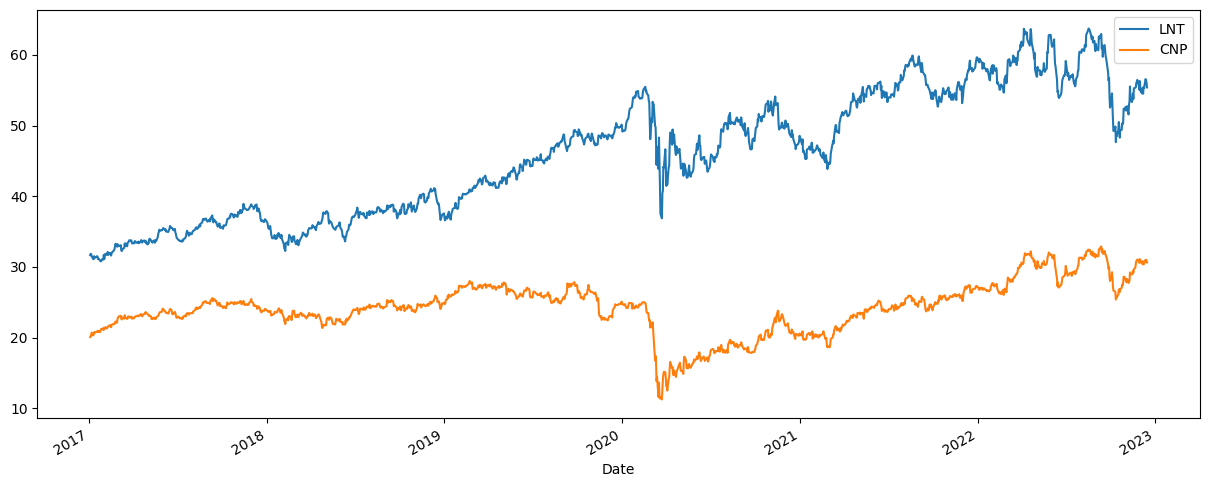

In [182]:
Asset1 = yf.download('LNT', start='2017-01-01', end='2022-12-16')
Asset1['Adj Close'].plot(figsize=(15,6),label='LNT')
Asset2 = yf.download('CNP', start='2017-01-01', end='2022-12-16')
Asset2['Adj Close'].plot(figsize=(15,6),label='CNP')
plt.legend()
plt.show()

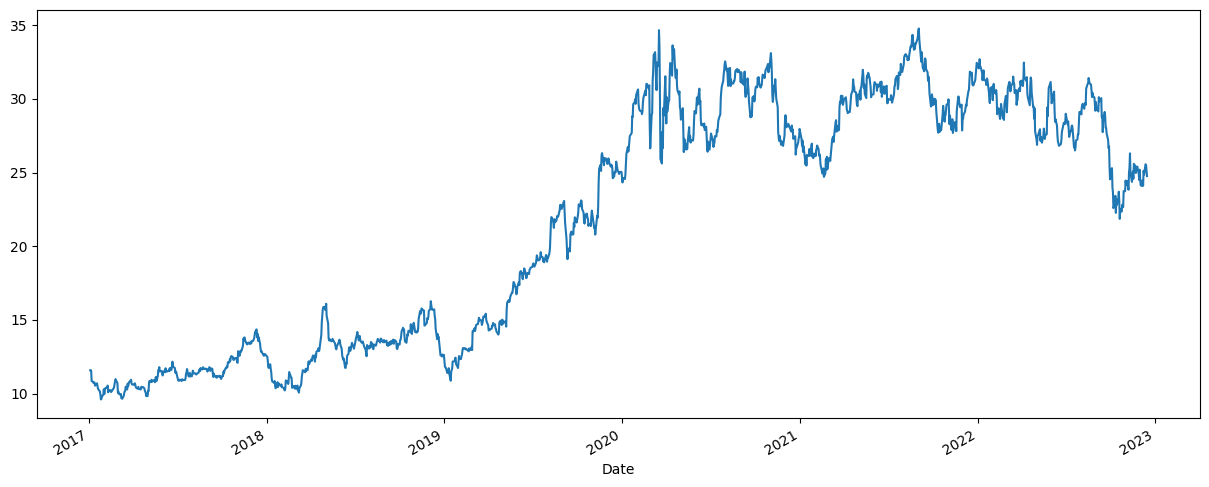

In [183]:
spread = np.abs(Asset1['Adj Close'] - Asset2['Adj Close'])
spread.plot(figsize=(15,6))
plt.show()

In [184]:
dates = pd.date_range('2017-01-03','2022-12-16',freq='B')
df1=pd.DataFrame(index=dates)
spread_df=df1.join(spread)
spread_df

,Adj Close
2017-01-03,11.585999
2017-01-04,11.598379
2017-01-05,11.556637
2017-01-06,10.848820
2017-01-09,10.806646
...,...
2022-12-12,25.559999
2022-12-13,25.509998
2022-12-14,25.099998
2022-12-15,24.760000


In [185]:
spread_df_norm=spread_df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
spread_df_norm['Adj Close'] = scaler.fit_transform(spread_df_norm['Adj Close'].values.reshape(-1,1))
spread_df_norm.head()

,Adj Close
2017-01-03,-0.842742
2017-01-04,-0.841757
2017-01-05,-0.845075
2017-01-06,-0.901335
2017-01-09,-0.904687


In [186]:
def data(asset, look_back):
    asset = asset
    data = []
    
    #All combinations of data given look back value
    for i in range(len(asset) - look_back): 
        data.append(asset[i: i + look_back])
    
    data = np.array(data);
    test_len = int(np.round(0.25*data.shape[0]))
    train_val_len = data.shape[0] - (test_len)
    val_len = int(np.round(0.1*train_val_len))
    train_len= data.shape[0] - (val_len)-test_len

    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_val = data[train_len:train_len+val_len,:-1,:]
    y_val = data[train_len:train_len+val_len,-1,:]
    
    x_test = data[train_len+val_len:,:-1]
    y_test = data[train_len+val_len:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [193]:
look_back = 2 # choose sequence length
x_train, y_train,x_val,y_val, x_test, y_test = data(spread_df_norm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1048, 1, 1)
y_train.shape =  (1048, 1)
x_val.shape =  (116, 1, 1)
y_val.shape =  (116, 1)
x_test.shape =  (388, 1, 1)
y_test.shape =  (388, 1)


In [194]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [195]:
y_train.size(),x_train.size(),y_val.size(),x_val.size(),y_test.size(),x_test.size() #confirm dimensions so can set the correct parameters for neural network below


(torch.Size([1048, 1]),
 torch.Size([1048, 1, 1]),
 torch.Size([116, 1]),
 torch.Size([116, 1, 1]),
 torch.Size([388, 1]),
 torch.Size([388, 1, 1]))

In [196]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #make hidden state 0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #detach so can do truncated backprop 
        out = self.fc(out[:, -1, :]) 
        return out

In [197]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 10, num_layers=5, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [198]:
num_epochs = 1000
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_prediction = model(x_train) #forward pass

    loss_ = loss(y_train_prediction, y_train)
    if t % 100 == 0 and t !=0:
        print("Epoch", t, "MSE: ", loss_.item())
    hist[t] = loss_.item()
    optimiser.zero_grad()
    loss_.backward() #backward pass
    optimiser.step() #update parameters

Epoch 100 MSE:  0.3547361493110657
Epoch 200 MSE:  0.02344360016286373
Epoch 300 MSE:  0.0062536136247217655
Epoch 400 MSE:  0.003782563144341111
Epoch 500 MSE:  0.002614082070067525
Epoch 600 MSE:  0.002034108154475689
Epoch 700 MSE:  0.0017065185820683837
Epoch 800 MSE:  0.001519742188975215
Epoch 900 MSE:  0.0014272170374169946


In [199]:
y_val_prediction=model(x_val)
y_test_prediction = model(x_test)

y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_val_prediction = scaler.inverse_transform(y_val_prediction.detach().numpy())
y_val = scaler.inverse_transform(y_val.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train RMSE Score:',trainScore)
valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_prediction[:,0]))
print('Val RMSE Score:',valScore)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test RMSE Score:', testScore)

Train RMSE Score: 0.46906363802879175
Val RMSE Score: 0.49115355442756653
Test RMSE Score: 0.5868333707107204


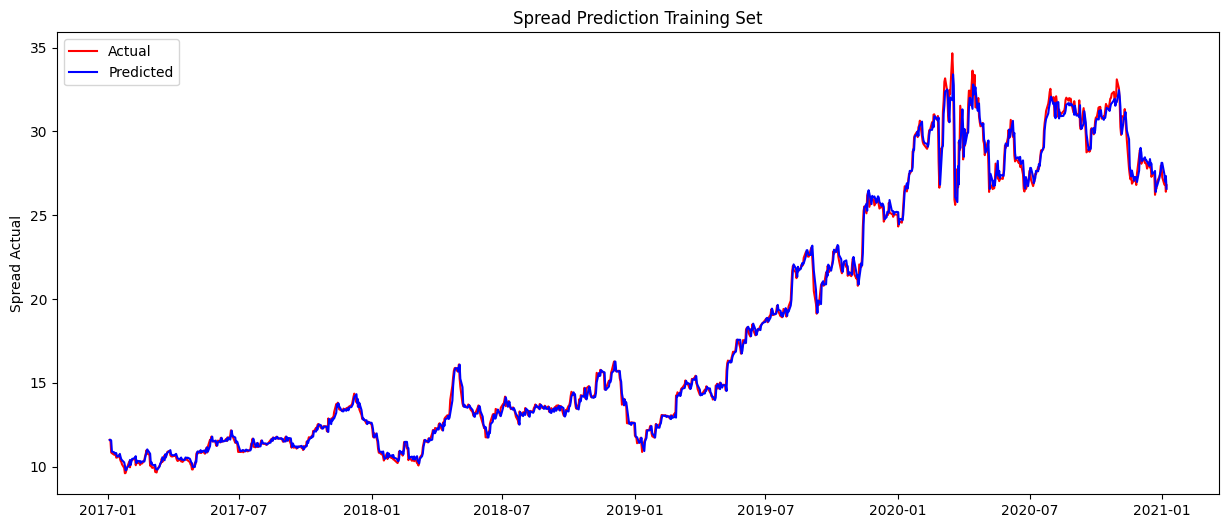

In [205]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[:len(y_train)].index, y_train, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[:len(y_train)].index, y_train_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Training Set')
plt.ylabel('Spread Actual')
plt.legend()
plt.show()

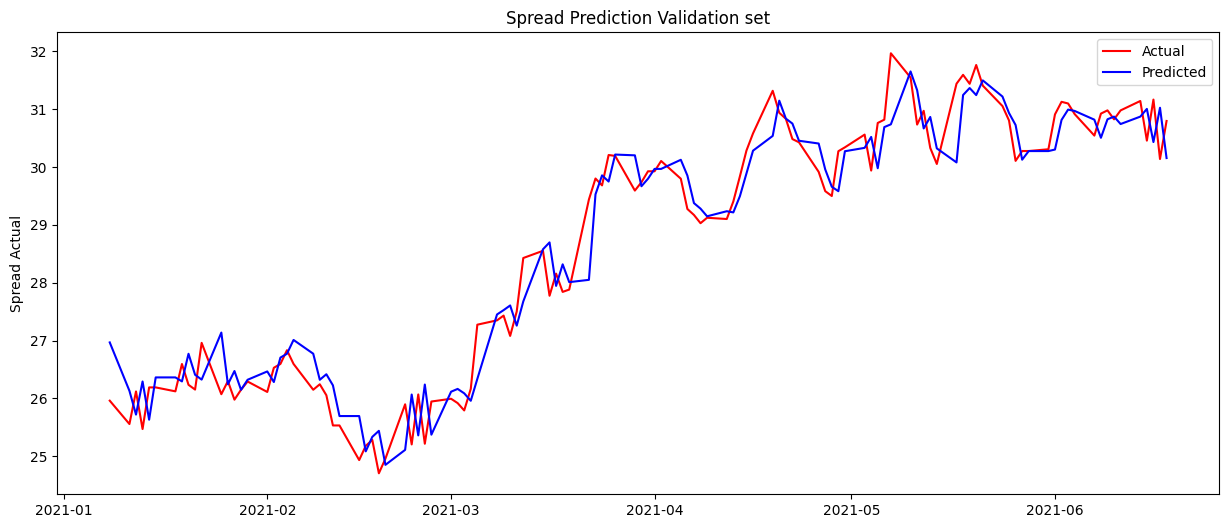

In [208]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Validation set')
plt.ylabel('Spread Actual')
plt.legend()
plt.show()

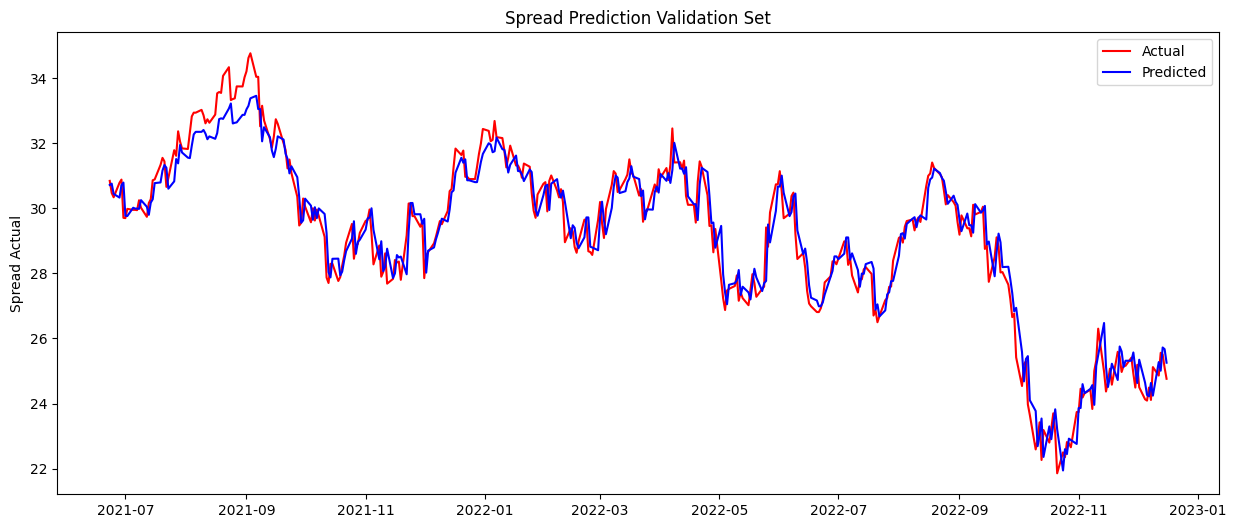

In [212]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Validation Set')
plt.ylabel('Spread Actual')
plt.legend()
plt.show()